<div style="text-align: center;">
    <h1> <font style="bold"> Ejercicio de Optimizaci√≥n de Recomendaciones de Productos para Quilmes </font></h1>
    <h2><font style="bold">Test T√©cnico: An√°lisis Exploratorio </font></h2>
    <h3><font style="bold">Abril Noguera</font></h3>
</div>

Este notebook se centra en el **an√°lisis exploratorio** de la informaci√≥n obtenida para entender las tendencias, patrones y posibles irregularidades en los datos de ventas, con el objetivo de optimizar las estrategias de recomendaci√≥n y asegurar que se alineen con las metas y restricciones comerciales del √°rea de ventas.

## Descripci√≥n del Problema

El desaf√≠o consiste en ajustar las recomendaciones de productos de Quilmes bajo las siguientes restricciones:
1. Ning√∫n producto debe tener m√°s de 200% de recomendaciones en comparaci√≥n con sus compradores del √∫ltimo mes, ni menos del 75%.
2. El segmento premium debe tener al menos un 20% de las recomendaciones totales.
3. El producto "Brahma Dorada-1 Lts-Bottle-RET" debe tener al menos 200 clientes con recomendaci√≥n.

## Metodolog√≠a

Para abordar este problema, se realizar√° lo siguiente:
1. **An√°lisis Exploratorio de Datos (EDA)**: Inspecci√≥n y limpieza de los datos para entender la estructura y las caracter√≠sticas clave.
2. **Aplicaci√≥n de Restricciones**: Implementaci√≥n de las restricciones para ajustar los objetivos de recomendaci√≥n.
3. **An√°lisis de Impacto**: Evaluaci√≥n del impacto de los ajustes en las recomendaciones generales y en segmentos espec√≠ficos.

## Implementaci√≥n

In [282]:
# Importaci√≥n de librer√≠as
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
from unidecode import unidecode
import re
import matplotlib.pyplot as plt
import seaborn as sns
import circlify
import scipy.stats as stats

In [283]:
# Configuraci√≥n para visualizaci√≥n de datos
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

In [284]:
# Configurar Matplotlib para mostrar gr√°ficos en el notebook
%matplotlib inline

# Configuraciones de estilo de Seaborn para un look minimalista
sns.set(style="whitegrid")

### An√°lisis Exploratorio de Datos (EDA)

**Objetivo**: El prop√≥sito de esta secci√≥n es realizar un an√°lisis preliminar de los datos proporcionados. Se busca identificar patrones, inconsistencias, valores faltantes y obtener una comprensi√≥n general de los datos con los que trabajaremos.

**Procedimiento**: Empezaremos importando los datos y realizando una inspecci√≥n inicial para comprender su estructura y composici√≥n. Posteriormente, analizaremos estad√≠sticas descriptivas, distribuciones y posibles correlaciones entre las variables. Este paso es crucial para asegurar la calidad de los datos antes de aplicar cualquier ajuste basado en las restricciones del problema.

In [285]:
# Carga de Base de Datos
df = pd.read_excel('data_ejercicio.xlsx', sheet_name='recommendations')
df1 = pd.read_excel('data_ejercicio.xlsx', sheet_name='customers_last_month')
df2 = pd.read_excel('data_ejercicio.xlsx', sheet_name='products')

In [286]:
len(df)

6399

Se une las recomendaciones con los detalles del producto.

In [287]:
# Identificar que los duplicados de la base de productos solo varien en el sku
print("Cantidad de productos recomendados: ",df['product_desc'].nunique())
print("Cantidad de productos descritos: ", len(df2.groupby(['product_desc','brand_family', 'brand', 'pack', 'brand_segment_I'])))

Cantidad de productos recomendados:  117
Cantidad de productos descritos:  117


In [288]:
# Se eliminan los duplicados de sku, ya que no aportan informaci√≥n
df2 = df2.drop_duplicates(subset=['product_desc'])
df2 = df2.drop(['sku_id'], axis=1)

In [289]:
# Agrego los detalles de los productos recomendados
df = pd.merge(df, df2, how='left', on='product_desc')

In [290]:
# Inspecci√≥n inicial de los datos
df.head()

customer_id                        product_desc  ranking  \
0       122053             Brahma-1 Lts-Bottle-RET        1   
1       122053                 Brahma-1/2 Lts-Cans        2   
2       139102    Stella artois Noire-1/2 Lts-Cans        1   
3       139102  Quilmes Bajo Cero-1 Lts-Bottle-RET        2   
4       139102          Stella artois-1/2 Lts-Cans        3   

        brand_family                brand              pack brand_segment_I  
0             Brahma               Brahma  1 Lts-Bottle-RET            Core  
1             Brahma               Brahma      1/2 Lts-Cans            Core  
2      Stella Artois  Stella artois Noire      1/2 Lts-Cans         Premium  
3  Quilmes Bajo Cero    Quilmes Bajo Cero  1 Lts-Bottle-RET           Value  
4      Stella Artois        Stella artois      1/2 Lts-Cans         Premium

Columnas:
- *customer_id*: N√∫mero de identificaci√≥n del cliente.
- *product_desc*: Descripci√≥n del producto (Marca-Litros-Formato).
- *ranking*: Ranking de recomendaci√≥n de cada producto para cada cliente.
- *brand_family*: Marca de cerveza.
- *brand*: Marca y producto especifico.
- *pack*: Descripci√≥n del tama√±o y envase.
- *brand_segment_I*: segmento de recomendaci√≥n del producto.

In [291]:
# Division de la descripci√≥n del producto en columnas: Marca, Litros y Formato
temp_df = df['product_desc'].str.split('-', expand=True)

In [292]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6399 entries, 0 to 6398
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       6399 non-null   object
 1   1       6399 non-null   object
 2   2       6399 non-null   object
 3   3       2585 non-null   object
dtypes: object(4)
memory usage: 200.1+ KB


La division no tiene nulos en las primeras 3 partes. La segunda caracter√≠stica del formato es especifica para algunos envases.

In [293]:
df['litros'] = temp_df[1]
df['formato'] = temp_df[2].str.cat(temp_df[3], sep=' ', na_rep='')

# Eliminar espacios en blanco al principio y al final de las cadenas de texto
df['formato'] = df['formato'].apply(lambda col: col.strip())

In [294]:
# Informaci√≥n de los datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6399 entries, 0 to 6398
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer_id      6399 non-null   int64 
 1   product_desc     6399 non-null   object
 2   ranking          6399 non-null   int64 
 3   brand_family     6399 non-null   object
 4   brand            6399 non-null   object
 5   pack             6399 non-null   object
 6   brand_segment_I  6399 non-null   object
 7   litros           6399 non-null   object
 8   formato          6399 non-null   object
dtypes: int64(2), object(7)
memory usage: 450.1+ KB


In [295]:
# Descripci√≥n de los datos
df.describe()

customer_id      ranking
count    6399.000000  6399.000000
mean   419659.135646     3.918737
std    113819.456889     2.676579
min     59564.000000     1.000000
25%    395109.500000     2.000000
50%    434493.000000     3.000000
75%    456249.000000     5.000000
max    695989.000000    12.000000

In [296]:
# Cambio de tipo de datos a texto para que sea reconocido por el Profile Report
df['brand_family'] = df['brand_family'].astype(str)
df['brand'] = df['brand'].astype(str)

In [297]:
# Profile Report
profile = ProfileReport(df, title="Informe Exploratorio", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### üìù Conclusiones:

- **An√°lisis de Clientes**: Se presentan 1247 clientes distintos. Se debe analizar la proporci√≥n de recomendaciones que se le hacen a cada uno de los clientes.
- **An√°lisis de Ratings**: Los ratings van de 1 a 12, pero la mayor√≠a de los ratings se dan para los primeros puestos.
- **An√°lisis de Variable Marca**: La variable brand podr√≠a contener valores repetidos que se est√°n tomando como valores distintos aunque representan lo mismo. Analizar y procesar variables seg√∫n may√∫sculas, tildes y espacios. Adem√°s, se podr√≠a analizar la jerarqu√≠a entre la family brand y el producto especifico.
- **An√°lisis de Variable Litros**: La variable litros se presenta como texto, pero se podr√≠a procesar como una variable num√©rica. La variable este desbalanceada siendo el 51.7% de 1/2 litro. Se deben analizar outliers ya que hay pocos registros de muy gran tama√±o.
- **An√°lisis de Variable Formato**: Hay 3 tipos de envases lata, botella y barril. La botella tiene dos tipos distintos RET y OW. Por lo que hay 4 valores √∫nicos.
- **An√°lisis de Segmentos**
- **Relaci√≥n entre Variables**: Los litros y el formato podr√≠an tener una relaci√≥n ya que dependiendo del envase el tama√±o que podr√° tomar. Al haber menos datos de barriles se entiende que los haya menos valores grandes en litros.
- **An√°lisis de Clientes Ultimo Mes**: Se analizara la repercusi√≥n que se obtuvo en las compras de cada producto.

#### An√°lisis de Clientes y Ratings:

Es necesario comprender c√≥mo se distribuyen las recomendaciones a lo largo de nuestra base de clientes. Este an√°lisis brinda perspectivas valiosas sobre el alcance y la efectividad de nuestras estrategias de recomendaci√≥n.

In [298]:
color_barras = "#365CDF"
color_fondo = "#EEEFF0"
color_texto = "#000000"

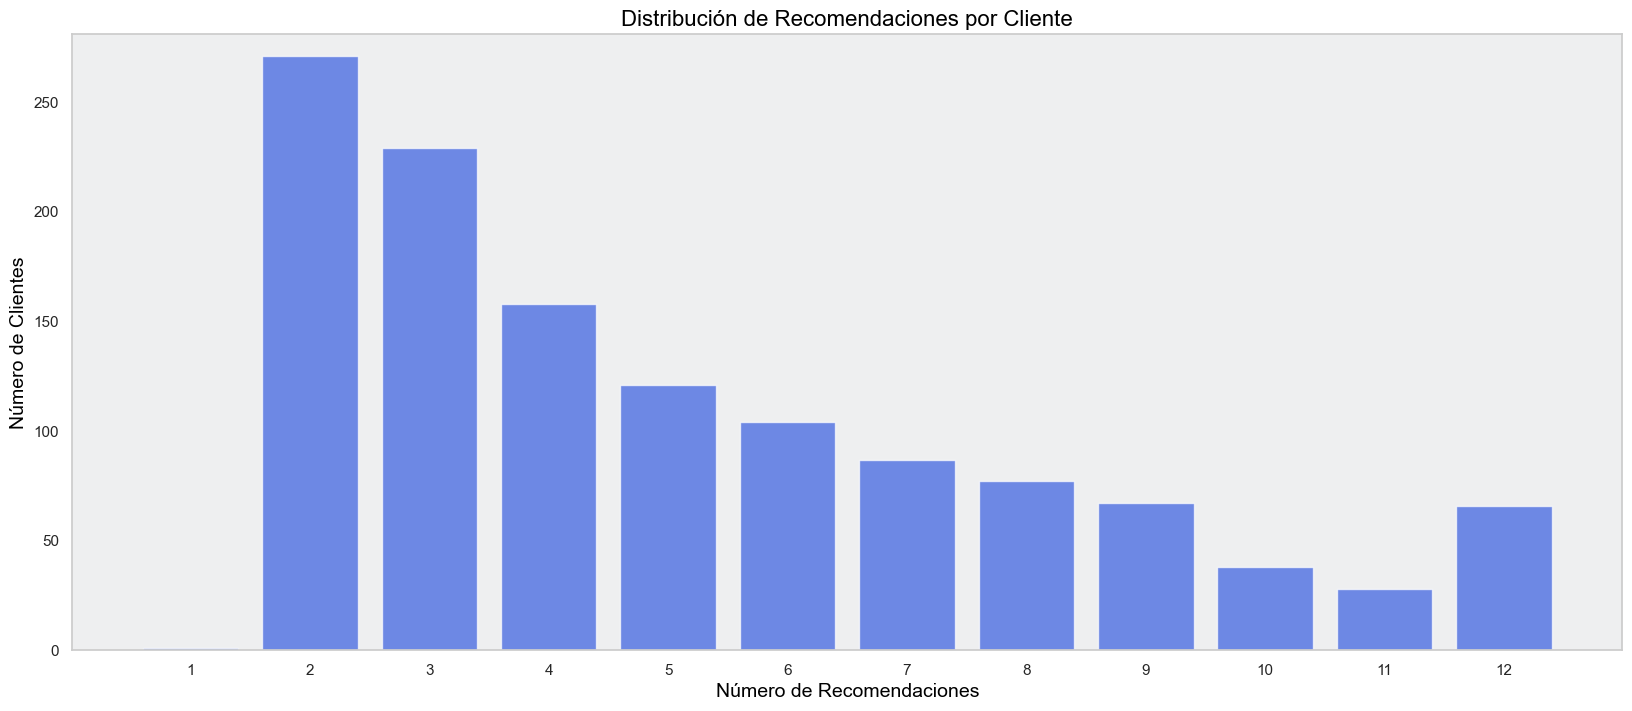

In [299]:
# Contar recomendaciones por cliente
conteo_recomendaciones = df.groupby('customer_id')['ranking'].count()

# Calcular la frecuencia de cada cantidad de recomendaciones
frecuencias = conteo_recomendaciones.value_counts().sort_index()

# Crear el gr√°fico de barras
plt.figure(figsize=(20, 8))
plt.bar(frecuencias.index, frecuencias.values, color=color_barras, alpha=0.7)

# Establecer el color del fondo
plt.gca().set_facecolor(color_fondo)

# Eliminar la cuadr√≠cula
plt.grid(False)

# Ajustar los ticks en el eje x para que muestren todas las cantidades de recomendaciones
plt.xticks(frecuencias.index)

# Establecer el t√≠tulo y las etiquetas con los colores correspondientes
plt.title('Distribuci√≥n de Recomendaciones por Cliente', fontsize=16, color=color_texto)
plt.xlabel('N√∫mero de Recomendaciones', fontsize=14, color=color_texto)
plt.ylabel('N√∫mero de Clientes', fontsize=14, color=color_texto)

# Ajustar l√≠mites del eje y si es necesario para mejorar la visualizaci√≥n
plt.ylim(0, frecuencias.values.max() + 10)

# Mostrar el gr√°fico
plt.show()

In [300]:
# Calcular estad√≠sticas de tendencia central
estadisticas_centrales = conteo_recomendaciones.agg(['mean', 'median', 'std', 'min', 'max', lambda x: x.mode().values[0]]).rename({'<lambda>': 'mode'})

# Imprimir estad√≠sticas en un formato limpio
print(estadisticas_centrales.to_string())

mean       5.131516
median     4.000000
std        2.959929
min        1.000000
max       12.000000
mode       2.000000


- Pocos clientes reciben unicamente una recomendaci√≥n, como m√≠nimo se sugirieron dos y esta cantidad de recomendaciones es la m√°s repetida.
- En promedio los clientes reciben 4 recomendaciones.
- El m√°ximo de recomendaciones es de 12, pero son pocos los clientes que reciben m√°s de 10 recomendaciones.

Adem√°s, se comprueba que por cada cliente al que se le hace recomendaciones no haya puestos vac√≠os. Es decir, si un cliente tiene una recomendaci√≥n con ranking 3 si o si deber√° tener recomendaci√≥n con ranking 1 y 2.

In [301]:
# Paso 1: Obtener los rankings √∫nicos en el DataFrame
rankings_unicos = df['ranking'].unique()

# Paso 2: Agrupar por 'customer_id' y obtener todos los 'ranking' para cada cliente
clientes_rankings = df.groupby('customer_id')['ranking'].apply(set).reset_index()

# Paso 3: Verificar si para cada cliente los rankings son consecutivos desde 1 hasta su m√°ximo
def verificacion_consecutiva(rankings_cliente):
    return set(range(1, max(rankings_cliente) + 1)) == rankings_cliente

# Aplicar la verificaci√≥n a cada cliente
clientes_rankings['verificacion'] = clientes_rankings['ranking'].apply(verificacion_consecutiva)

# Filtrar aquellos clientes que no cumplen con la condici√≥n
clientes_incompletos = clientes_rankings[~clientes_rankings['verificacion']]

# Mostrar los clientes que no cumplen con la condici√≥n
if(len(clientes_incompletos) > 0):
    print(clientes_incompletos[['customer_id', 'ranking']])
else:
    print('Todos los clientes tienen rankings consecutivos desde 1 hasta su m√°ximo')

Todos los clientes tienen rankings consecutivos desde 1 hasta su m√°ximo


‚úÖ Se cumple esta verificaci√≥n!

#### An√°lisis de Marca:

Para procesar la variable que contiene los nombres de las marcas y productos de cerveza se debe:
1. Identificar Marcas y Productos: Si las marcas tienen un conjunto de nombres conocidos, podr√≠as usar eso para identificar y separar la marca del resto del producto.
2. Crear Nuevas Variables: Bas√°ndote en la estructura de los nombres, podr√≠as crear nuevas variables para 'marca' y 'producto'. Para nombres que solo tienen la marca, el producto podr√≠a estar vac√≠o o tener un valor predeterminado como 'General'.

In [302]:
# An√°lisis de Valores √önicos de la Variable Marca
print(df['brand'].unique())
print(df['brand_family'].unique())

['Brahma' 'Stella artois Noire' 'Quilmes Bajo Cero' 'Stella artois'
 'Patagonia Amber Lager' 'Goose Island Hazy' 'Temple Scottish'
 'Andes Origen Fresquita' 'Quilmes Clasica' 'Stella Artois Blanche'
 'Corona' 'Brahma Dorada' 'Quilmes 0.0' 'Budweiser'
 'Patagonia Bohemian Pilsener' 'Quilmes Ipa' 'Michelob Ultra' 'Andes'
 'Andes Origen Roja' 'Andes Origen IPA' '27 Eazy' '1890'
 'Patagonia Vera Ipa' 'Andes Origen Negra' 'Patagonia 24.7' 'Temple Wolf'
 'Quilmes Stout' 'Andes Origen Rubia' 'Patagonia Indira' 'Quilmes Bock'
 'Patagonia Hoppy Lager' 'Patagonia Weisse' 'Stella artois 0.0%'
 'Patagonia Travesia' 'Goose Island' 'Andes Origen Criolla'
 'Andes Origen IPA Roja' 'Temple Honey' 'Quilmes Red Lager'
 'Patagonia Solcitra' 'Patagonia abrazo oso' 'Quilmes Doble'
 'Andes Origen Vendimia' 'Temple Golden' 'Temple Cosmica' 'Patagonia Kune'
 'Patagonia Old Ale']
['Brahma' 'Stella Artois' 'Quilmes Bajo Cero' 'Patagonia' 'Goose Island'
 'Temple' 'Andes Origen' 'Quilmes' 'Corona' 'Quilmes 0.0' 'B

In [303]:
# Procesamiento de la Variable Marca
df.loc[df['brand_family'] == 'Quilmes Variedades ', 'brand_family'] = 'Quilmes'
df.loc[df['brand_family'] == 'Andes', 'brand_family'] = 'Andes Origen'
df.loc[df['brand'] == 'Andes', 'brand'] = 'Andes Origen'

In [304]:
# Definici√≥n de marcas conocidas
marcas_conocidas = df['brand_family'].unique()
marcas_conocidas = sorted(marcas_conocidas, key=len, reverse=True)

In [305]:
# Funci√≥n para identificar la marca y el producto
def identificar_producto(nombre):
    for marca in marcas_conocidas:
        if nombre.startswith(marca):
            # El resto de la cadena despu√©s del nombre de la marca ser√≠a el producto
            producto = nombre[len(marca):].strip()
            return marca, producto if producto else 'Clasica'
    return 'desconocida', nombre

In [306]:
# Crear nuevas columnas  'producto' en el DataFrame
_, df['producto'] = zip(*df['brand'].apply(identificar_producto))

In [307]:
# Verificar los resultados
print(df[['brand_family', 'producto']].head())

        brand_family             producto
0             Brahma              Clasica
1             Brahma              Clasica
2      Stella Artois  Stella artois Noire
3  Quilmes Bajo Cero              Clasica
4      Stella Artois        Stella artois


In [308]:
# Preparar los datos para el gr√°fico de Circle Packing
data = df.groupby(['brand_family', 'brand']).size().reset_index(name='frecuencia')

# Agrupar y sumar las frecuencias por brand_family y producto
grouped_data = data.groupby(['brand_family', 'brand'])['frecuencia'].sum().reset_index()

# Crear una estructura de datos para almacenar la jerarqu√≠a
result = [{'id': 'Cervezas', 'datum': grouped_data['frecuencia'].sum(), 'children': []}]

# Iterar a trav√©s de las marcas y crear la jerarqu√≠a
for marca in grouped_data['brand_family'].unique():
    marca_data = grouped_data[grouped_data['brand_family'] == marca]
    marca_entry = {'id': marca, 'datum': marca_data['frecuencia'].sum(), 'children': []}

    for _, row in marca_data.iterrows():
        producto_entry = {'id': row['brand'], 'datum': row['frecuencia']}
        marca_entry['children'].append(producto_entry)

    result[0]['children'].append(marca_entry)

# Mostrar el resultado
print(result)

[{'id': 'Cervezas', 'datum': 6399, 'children': [{'id': '1890', 'datum': 100, 'children': [{'id': '1890', 'datum': 100}]}, {'id': '27 Eazy', 'datum': 19, 'children': [{'id': '27 Eazy', 'datum': 19}]}, {'id': 'Andes Origen', 'datum': 1106, 'children': [{'id': 'Andes Origen', 'datum': 4}, {'id': 'Andes Origen Criolla', 'datum': 5}, {'id': 'Andes Origen Fresquita', 'datum': 418}, {'id': 'Andes Origen IPA', 'datum': 207}, {'id': 'Andes Origen IPA Roja', 'datum': 27}, {'id': 'Andes Origen Negra', 'datum': 41}, {'id': 'Andes Origen Roja', 'datum': 221}, {'id': 'Andes Origen Rubia', 'datum': 175}, {'id': 'Andes Origen Vendimia', 'datum': 8}]}, {'id': 'Brahma', 'datum': 1632, 'children': [{'id': 'Brahma', 'datum': 957}, {'id': 'Brahma Dorada', 'datum': 675}]}, {'id': 'Budweiser', 'datum': 485, 'children': [{'id': 'Budweiser', 'datum': 485}]}, {'id': 'Corona', 'datum': 594, 'children': [{'id': 'Corona', 'datum': 594}]}, {'id': 'Goose Island', 'datum': 16, 'children': [{'id': 'Goose Island', 'dat

In [309]:
# Computar las posiciones de los c√≠rculos
circles = circlify.circlify(
    result, 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

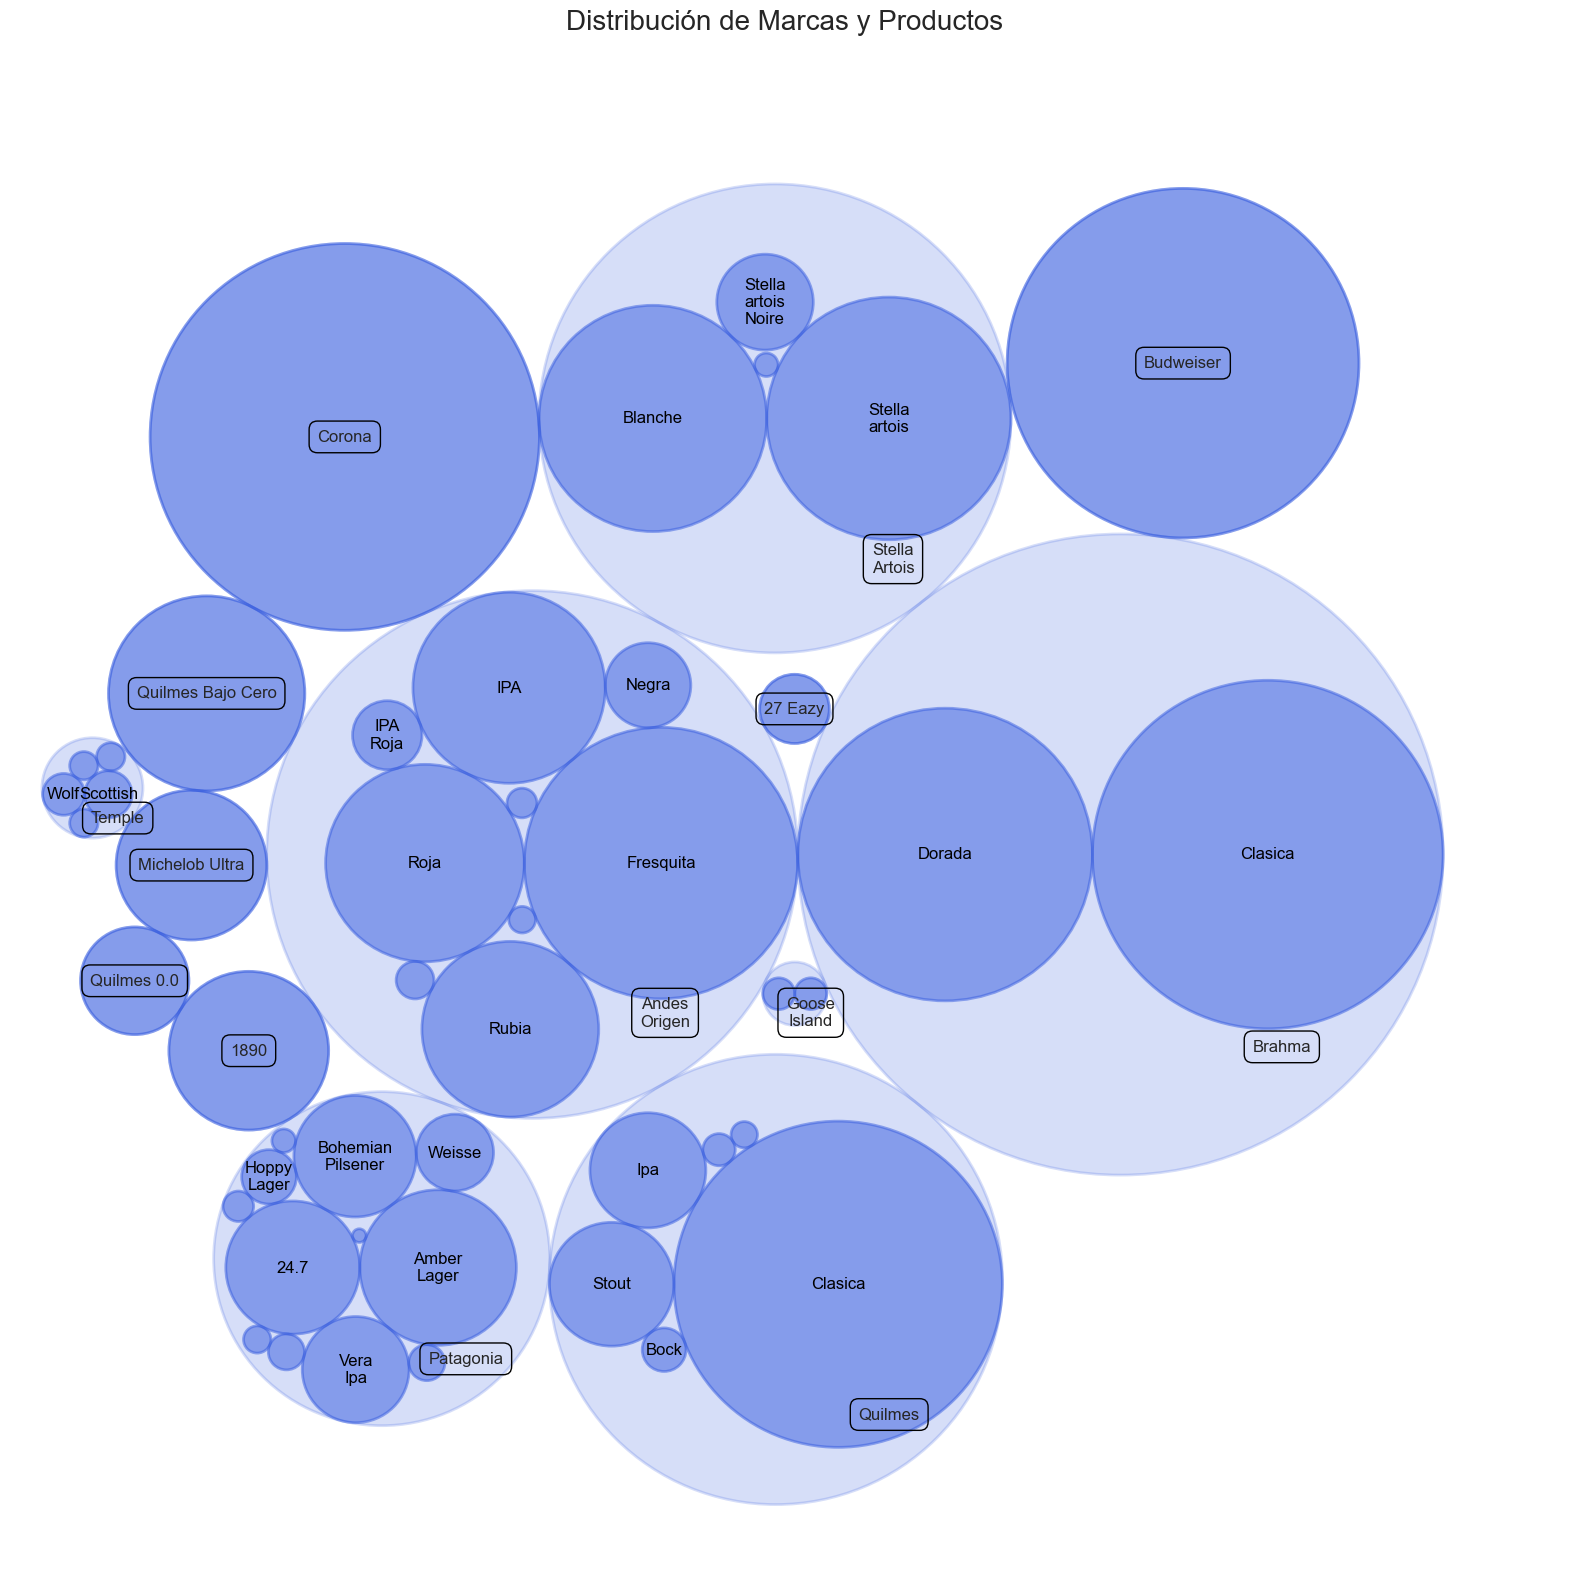

In [310]:
# Crear la figura
fig, ax = plt.subplots(figsize=(20,20))

# T√≠tulo
ax.set_title('Distribuci√≥n de Marcas y Productos', fontsize=20)

# Eliminar ejes
ax.axis('off')

# Encontrar limites en los ejes
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Filtra los productos con frecuencia baja frecuencia o poca diversidad.
productos_filtrados = data[data['frecuencia'] >= 10]
marcas_filtradas = data.groupby('brand_family').size().reset_index(name='frecuencia')
marcas_filtradas = marcas_filtradas.loc[marcas_filtradas['frecuencia'] == 1,'brand_family'].to_list()

# Imprimir c√≠rculos de mayor nivel
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2, color=color_barras))

# Imprimir c√≠rculos y etiquetas de productos con frecuencia mayor o igual a 10
for circle in circles:
    if circle.level != 3:
        continue
    x, y, r = circle
    parent, label = identificar_producto(circle.ex["id"])
    ax.add_patch(plt.Circle((x, y), r, alpha=0.5, linewidth=2, color=color_barras))

    # Verifica si el producto est√° en la lista de productos filtrados
    if (circle.ex["id"] in productos_filtrados['brand'].values) & (parent not in marcas_filtradas):
        if ' ' in label:
            label = label.replace(' ', '\n')
        plt.annotate(label, (x, y),va='center', ha='center', color=color_texto)


# Imprimir etiquetas para c√≠rculos de marcas
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    if label in marcas_filtradas:
        plt.annotate(label, (x, y) ,va='center', ha='center', bbox=dict(facecolor='none', edgecolor=color_texto, boxstyle='round', pad=0.5))
    else:
        if ' ' in label:
                label = label.replace(' ', '\n')
        plt.annotate(label, (x + 0.5 * r , y - 0.6 * r ) ,va='center', ha='center', bbox=dict(facecolor='none', edgecolor=color_texto, boxstyle='round', pad=0.5))


- Las marcas con mas presencia son mas diversas en sus productos. Excepto corona y budweiser que solo presentan su producto clasico.
- De misma forma, las marcas menos recomendadas no tienen mucha diversidad en sus productos. Exceptuando temple que tiene 5 tipos..
- La mayor√≠a de las marcas presentan una categor√≠a o tipo de producto clasico.
- La brahma es la cerveza mas recomendada.

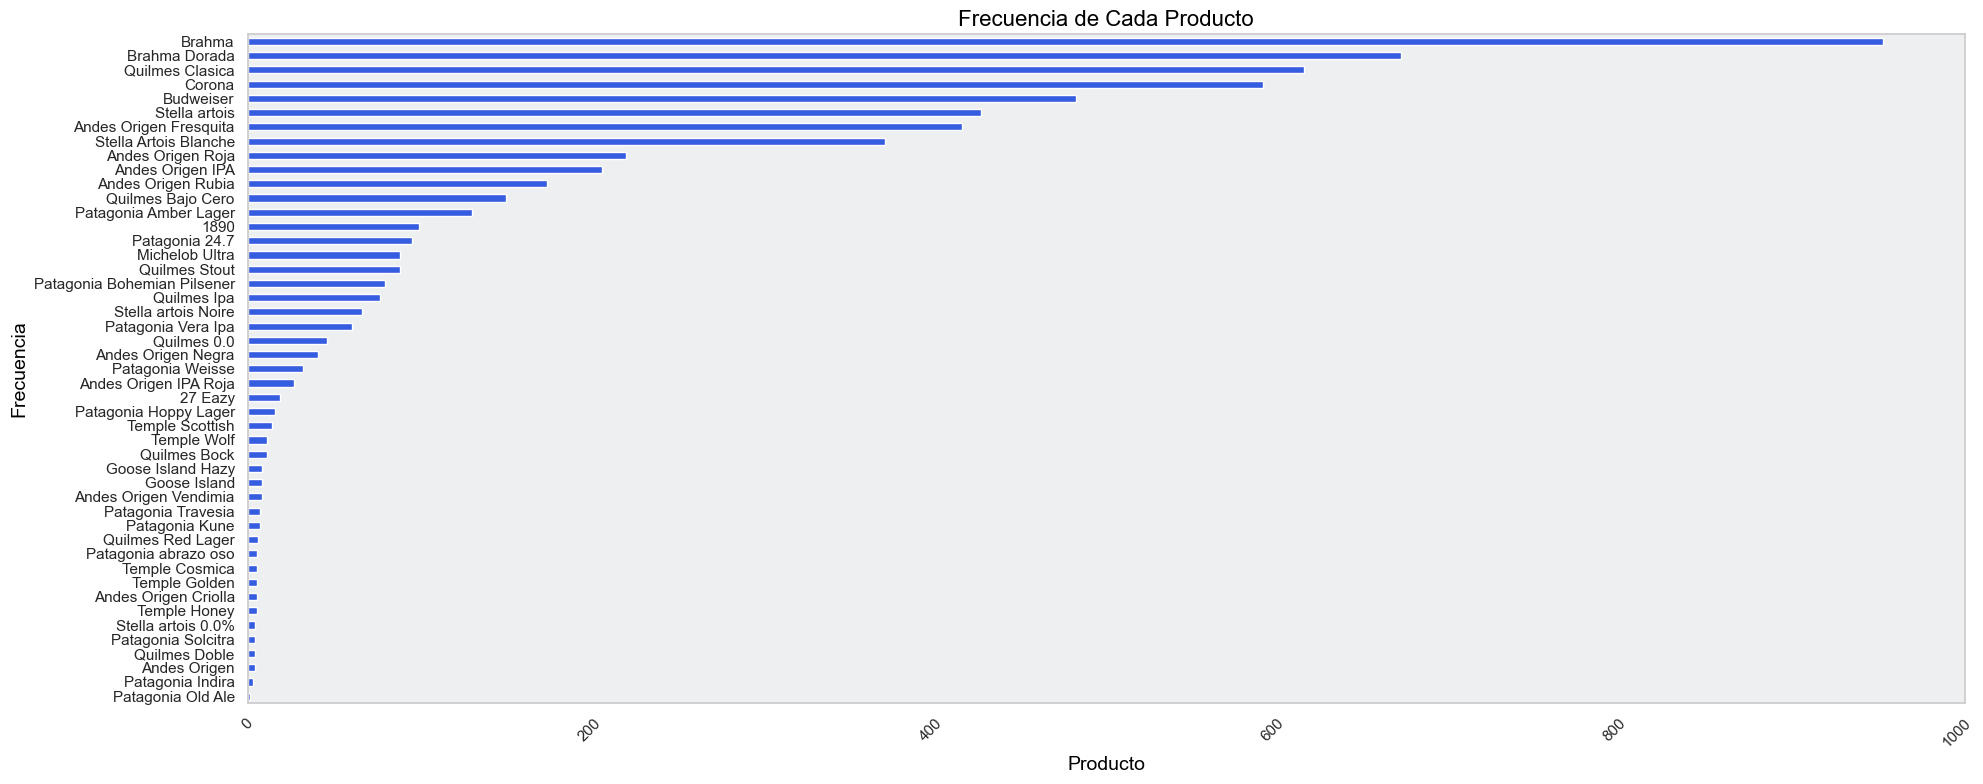

In [311]:
frecuencias_productos = df['brand'].value_counts().sort_values(ascending=True)

# Crear el gr√°fico de barras
plt.figure(figsize=(20, 8))
frecuencias_productos.plot(kind='barh', color=color_barras)

# Establecer el color del fondo
plt.gca().set_facecolor(color_fondo)

# Eliminar la cuadr√≠cula
plt.grid(False)

# Ajustar las etiquetas y el t√≠tulo con los colores correspondientes
plt.title('Frecuencia de Cada Producto', fontsize=16, color=color_texto)
plt.xlabel('Producto', fontsize=14, color=color_texto)
plt.ylabel('Frecuencia', fontsize=14, color=color_texto)

# Rotar las etiquetas del eje x para mejor legibilidad si es necesario
plt.xticks(rotation=45)

# Mostrar el gr√°fico
plt.tight_layout()
plt.show()

Se recomienda en mayor proporci√≥n la cerveza de Brahma, en segundo lugar la brahma dorada que es el producto estrella de la compa√±ia.

#### An√°lisis de Litros

In [312]:
# An√°lisis de Valores √önicos de la Variable Litros
print(df['litros'].unique())

['1 Lts' '1/2 Lts' '20 Lts' '30 Lts' '3/4 Lts' '1/3 Lts' '1/4 Lts'
 '50 Lts' '2/3 Lts' '20000 Lts' '1.2 Lts']


In [313]:
# Funci√≥n que convierte las fracciones y decimales a litros
def convertir_litros(valor):
    # Si el valor contiene una barra, asumimos que es una fracci√≥n
    if '/' in valor:
        fraccion = valor.split()[0]  # Obtenemos solo la fracci√≥n, sin 'lts'
        numerador, denominador = fraccion.split('/')
        return float(numerador) / float(denominador)
    # Si no, simplemente eliminamos el texto y convertimos a float
    else:
        return float(valor.split()[0])

In [314]:
# Aplicamos la funci√≥n a la columna 'litros'
df['ltrs'] = df['litros'].apply(convertir_litros)

In [315]:
df['ltrs'].head()

0    1.0
1    0.5
2    0.5
3    1.0
4    0.5
Name: ltrs, dtype: float64

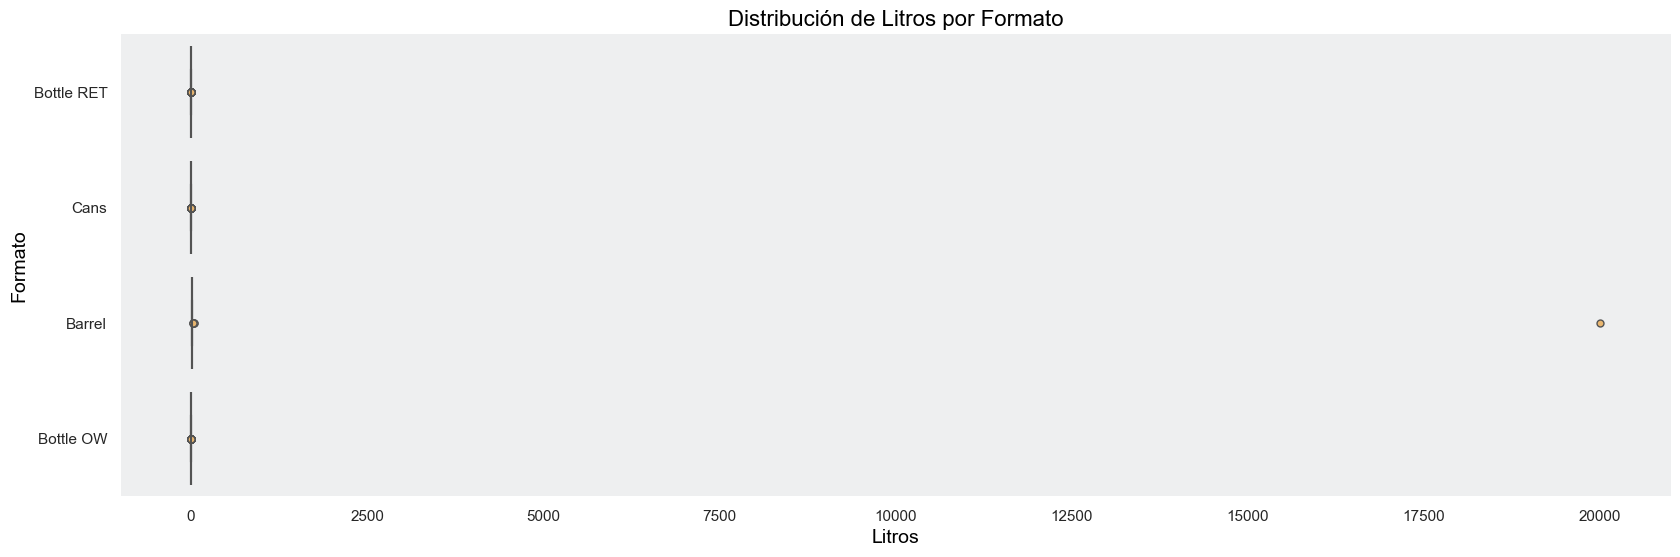

In [316]:
# Establecer el tama√±o de la figura (ancho, alto) para hacer el gr√°fico m√°s ancho
fig, ax = plt.subplots(figsize=(20, 6))

# Crear el boxplot dividido por 'formato'
sns.boxplot(x='ltrs', y='formato', data=df, palette=["#365CDF"], flierprops=dict(markerfacecolor='#E9B66F', marker='o', markersize=5))

# Configurar el color del fondo y desactivar la cuadr√≠cula
ax.set_facecolor('#EEEFF0')
ax.grid(False)

# Eliminar el borde del eje
for spine in ax.spines.values():
    spine.set_visible(False)

# Establecer el t√≠tulo y las etiquetas con los colores correspondientes
ax.set_title('Distribuci√≥n de Litros por Formato', fontsize=16, color='#000000')
ax.set_xlabel('Litros', fontsize=14, color='#000000')
ax.set_ylabel('Formato', fontsize=14, color='#000000')

# Mostrar el gr√°fico
plt.show()

Resulta que el valor de 20000 litros en la variable es at√≠pico tambi√©n para los barriles. Analizamos el registro:

In [317]:
# Registros con valores at√≠picos
df[df['ltrs'] == 20000]

customer_id                         product_desc  ranking brand_family  \
3691       442587  Patagonia Travesia-20000 Lts-Barrel        9    Patagonia   

                   brand              pack brand_segment_I     litros formato  \
3691  Patagonia Travesia  20000 Lts-Barrel   Super Premium  20000 Lts  Barrel   

      producto     ltrs  
3691  Travesia  20000.0

In [318]:
# Eliminaci√≥n de registros con valores at√≠picos
df = df[df['ltrs'] < 100]

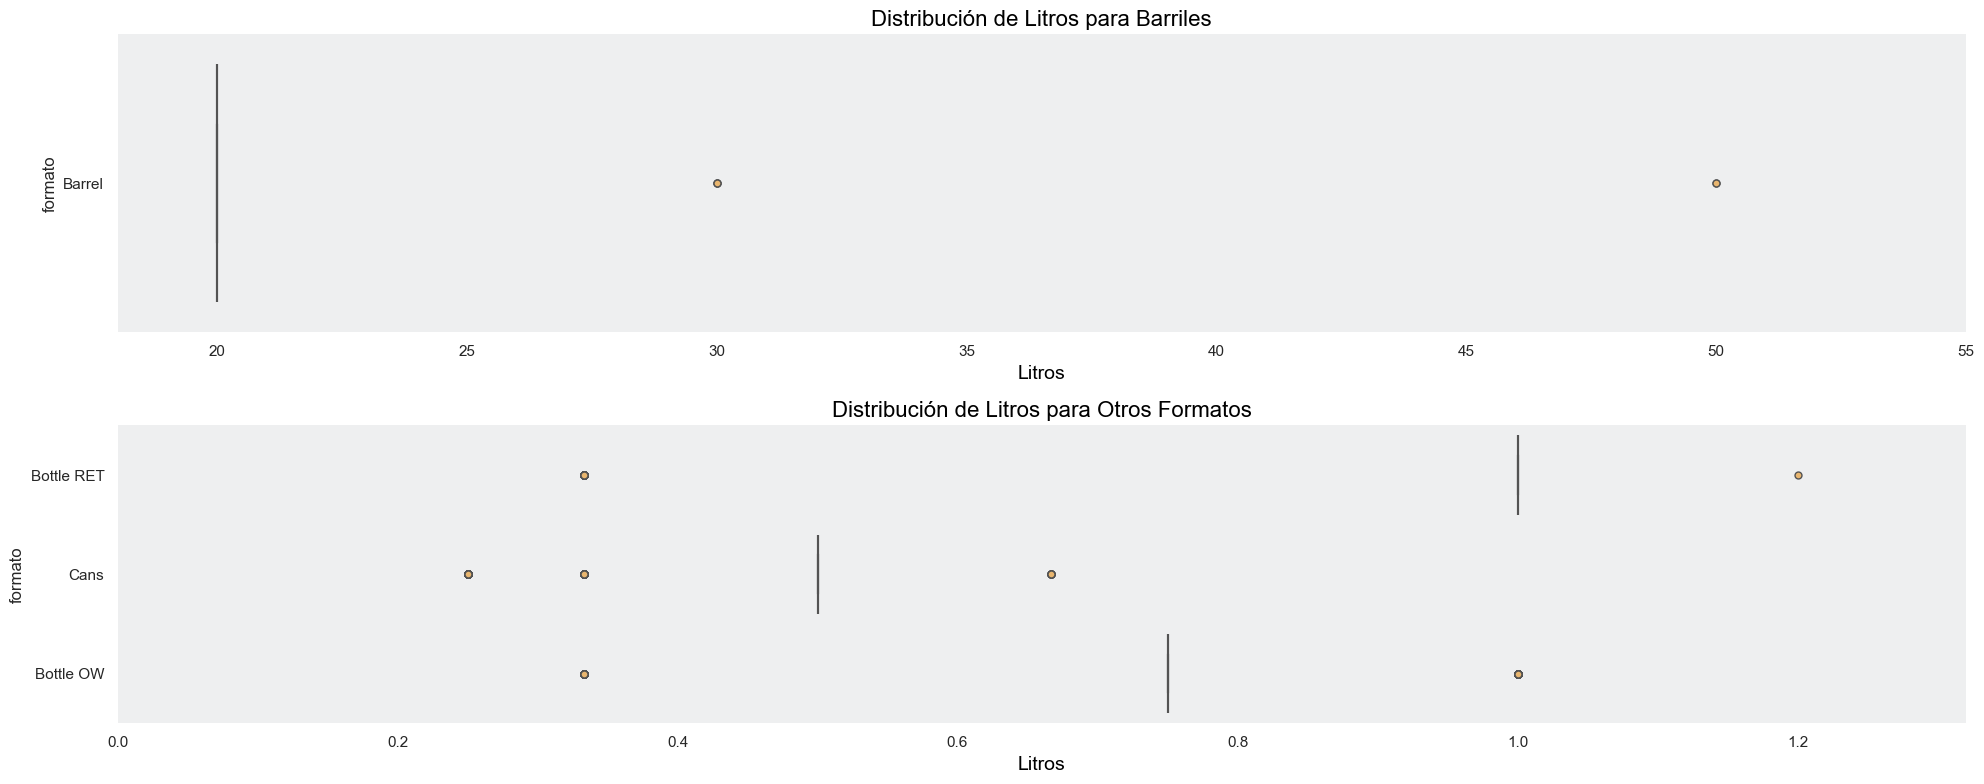

In [319]:
# Filtrar el DataFrame para 'Barrel'
df_barrel = df[df['formato'] == 'Barrel']
df_otros = df[df['formato'] != 'Barrel']

# Crear dos subplots, uno para 'Barrel' y otro para los dem√°s formatos
fig, axs = plt.subplots(2, 1, figsize=(20, 8), sharex=False)

# Primer boxplot para 'Barrel'
sns.boxplot(x='ltrs', y='formato', data=df_barrel, ax=axs[0], color="#365CDF", flierprops=dict(markerfacecolor='#E9B66F', marker='o', markersize=5))
axs[0].set_title('Distribuci√≥n de Litros para Barriles', fontsize=16, color='#000000')
axs[0].set_facecolor('#EEEFF0')
axs[0].grid(False)
# Establecer los l√≠mites del eje x para 'barrel' basado en su rango de datos
axs[0].set_xlim(left=df_barrel['ltrs'].min() * 0.9, right=df_barrel['ltrs'].max() * 1.1)

# Segundo boxplot para los dem√°s formatos
sns.boxplot(x='ltrs', y='formato', data=df_otros, ax=axs[1], color="#365CDF", flierprops=dict(markerfacecolor='#E9B66F', marker='o', markersize=5))
axs[1].set_title('Distribuci√≥n de Litros para Otros Formatos', fontsize=16, color='#000000')
axs[1].set_facecolor('#EEEFF0')
axs[1].grid(False)
# Establecer los l√≠mites del eje x para otros formatos basado en su rango de datos
axs[1].set_xlim(left=0, right=df_otros['ltrs'].max() * 1.1)

# Eliminar los bordes de los ejes
for ax in axs:
    for spine in ax.spines.values():
        spine.set_visible(False)

# Establecer las etiquetas de los ejes x
for ax in axs:
    ax.set_xlabel('Litros', fontsize=14, color='#000000')

# Ajustar el layout para evitar la superposici√≥n de los t√≠tulos de los subplots
plt.tight_layout()

# Mostrar el gr√°fico
plt.show()

En todos los tipos de envases hay una medida m√°s recomendada. Pero en algunos casos se sugieren otras medidas. Estos casos no se toman como outliers ya que sugieren tama√±os posibles para el envase.

In [320]:
# Agrupar por 'formato' y calcular las estad√≠sticas de tendencia central
estadisticas_tendencia_central = df.groupby('formato')['ltrs'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
modas = df.groupby('formato')['ltrs'].agg(lambda x: x.mode().tolist()).reset_index().rename(columns={'ltrs': 'mode'})

# Combinar las tablas de estad√≠sticas y modas si es necesario
estadisticas_completas = pd.merge(estadisticas_tendencia_central, modas, on='formato')

# Mostrar la tabla
estadisticas_completas

formato       mean  median       std        min        max    mode
0      Barrel  23.000000   20.00  7.943768  20.000000  50.000000  [20.0]
1   Bottle OW   0.668476    0.75  0.187970   0.333333   1.000000  [0.75]
2  Bottle RET   0.839247    1.00  0.285415   0.333333   1.200000   [1.0]
3        Cans   0.496123    0.50  0.031831   0.250000   0.666667   [0.5]

#### An√°lisis de Formato:

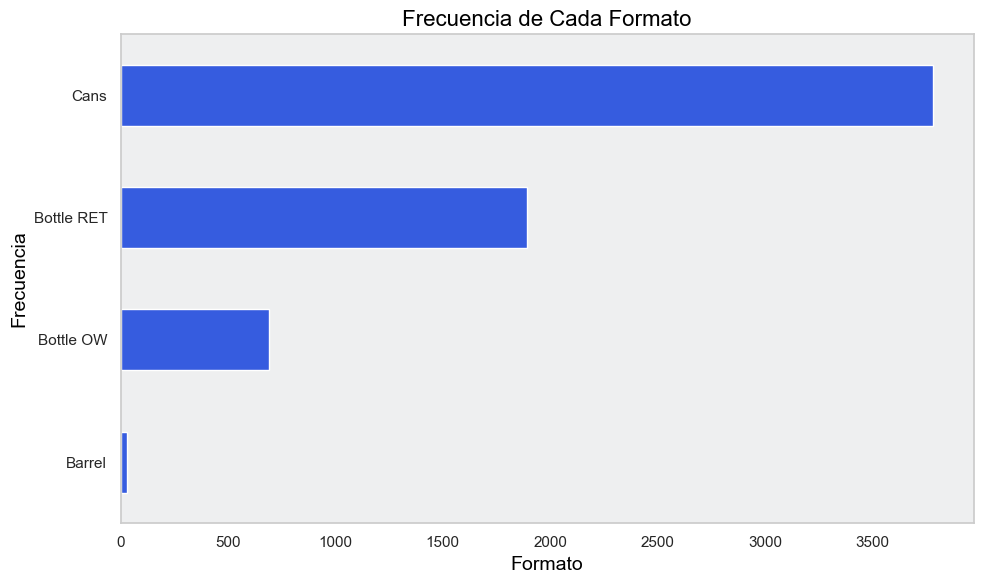

In [321]:
frecuencias_formatos = df['formato'].value_counts().sort_values(ascending=True)

# Crear el gr√°fico de barras
plt.figure(figsize=(10, 6))
frecuencias_formatos.plot(kind='barh', color=color_barras)

# Establecer el color del fondo
plt.gca().set_facecolor(color_fondo)

# Eliminar la cuadr√≠cula
plt.grid(False)

# Ajustar las etiquetas y el t√≠tulo con los colores correspondientes
plt.title('Frecuencia de Cada Formato', fontsize=16, color=color_texto)
plt.xlabel('Formato', fontsize=14, color=color_texto)
plt.ylabel('Frecuencia', fontsize=14, color=color_texto)


# Mostrar el gr√°fico
plt.tight_layout()
plt.show()

- Cans Predominantes: El formato 'cans' tiene la frecuencia m√°s alta, sugiriendo que es el m√°s com√∫n o popular entre los formatos disponibles.
- Segundo Lugar: 'bottle ret' es el segundo m√°s frecuente, aunque con significativamente menos frecuencia que 'cans'.
- Menos Comunes: 'bottle ow' y 'barrel' aparecen con mucha menos frecuencia, indicando que son los menos comunes o quiz√°s los m√°s especializados o de nicho en esta selecci√≥n de productos.

#### An√°lisis de Segmentos

Se analizan los segmentos de las marcas para explorar la distribuci√≥n y caracter√≠sticas de estas segmentaciones. Asi se obtienen insights valiosos que puedan guiar nuestras decisiones de negocio.

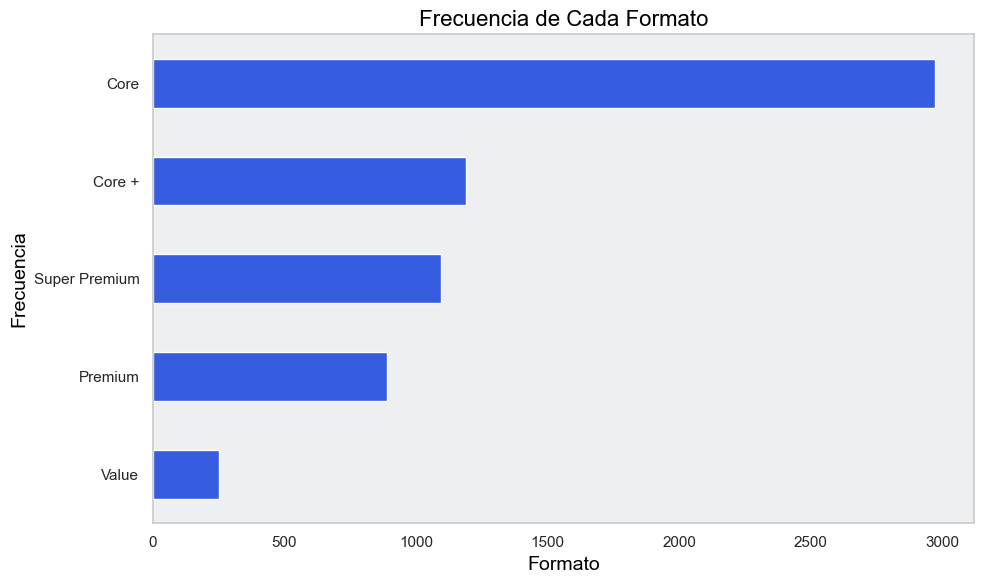

In [322]:
# An√°lisis de la frecuencia de cada segmento de marca
frecuencia_segmentos = df['brand_segment_I'].value_counts().sort_values(ascending=True)

# Crear el gr√°fico de barras
plt.figure(figsize=(10, 6))
frecuencia_segmentos.plot(kind='barh', color=color_barras)

# Establecer el color del fondo
plt.gca().set_facecolor(color_fondo)

# Eliminar la cuadr√≠cula
plt.grid(False)

# Ajustar las etiquetas y el t√≠tulo con los colores correspondientes
plt.title('Frecuencia de Cada Formato', fontsize=16, color=color_texto)
plt.xlabel('Formato', fontsize=14, color=color_texto)
plt.ylabel('Frecuencia', fontsize=14, color=color_texto)


# Mostrar el gr√°fico
plt.tight_layout()
plt.show()

- La mayor√≠a de las recomendaciones se concentran en el segmento core.
- No hay muchas recomendaciones de productos de segmento value.

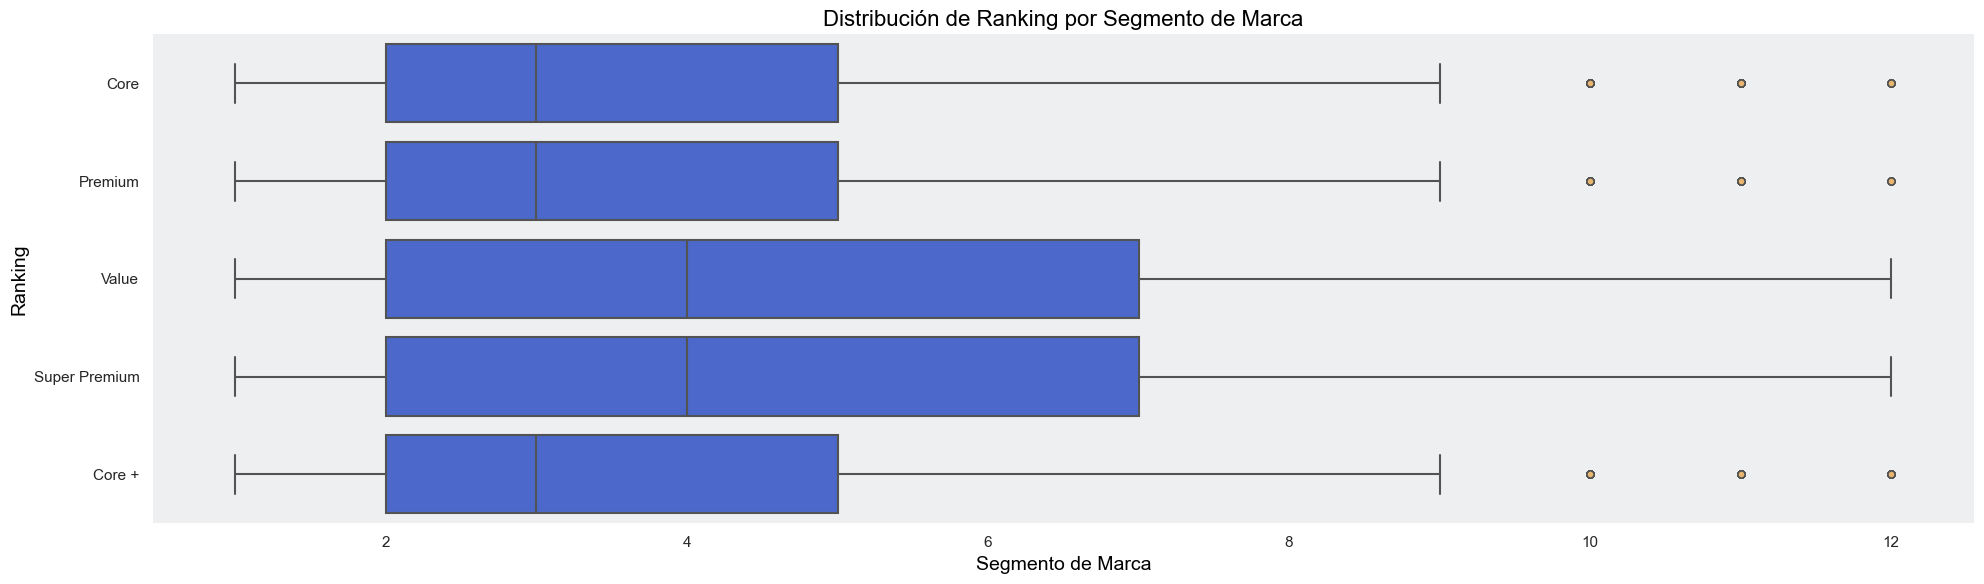

In [323]:
# Crear la figura
plt.figure(figsize=(20, 6))

# Crear boxplot 
sns.boxplot(y='brand_segment_I', x='ranking', data=df, color="#365CDF", flierprops=dict(markerfacecolor='#E9B66F', marker='o', markersize=5))

# Establecer t√≠tulo, color de fondo y eliminar la cuadr√≠cula
plt.title('Distribuci√≥n de Ranking por Segmento de Marca', fontsize=16, color='#000000')
plt.gca().set_facecolor('#EEEFF0')
plt.grid(False)

# Establecer las etiquetas de los ejes
plt.xlabel('Segmento de Marca', fontsize=14, color='#000000')
plt.ylabel('Ranking', fontsize=14, color='#000000')

# Eliminar los bordes de los ejes
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Ajustar el layout y mostrar el gr√°fico
plt.tight_layout()
plt.show()


- los segmentos value y super premium tienen amplia dispersion.
- Hay outliers en core, core + y premium, lo que podr√≠a se√±alar casos espec√≠ficos donde estos productos se desv√≠an de la tendencia com√∫n de recomendaciones.

#### An√°lisis de Compras √öltimo Mes

Este an√°lisis tiene como objetivo entender la relaci√≥n entre la cantidad de clientes que compraron productos espec√≠ficos el mes pasado y la cantidad de veces que esos productos fueron recomendados. Buscaremos patrones o correlaciones que puedan sugerir el impacto de las recomendaciones en las decisiones de compra de los clientes.

In [324]:
# Cantidad de recomendaciones por product_desc
conteo_recomendaciones = df.groupby('product_desc')['ranking'].count().reset_index(name='recomendaciones')

In [325]:
# Agrego la informaci√≥n de los productos recomendados, incluyendo los que no fueron comprados el ultimo mes (o no hay informaci√≥n al respecto)
df1 = df1.merge(conteo_recomendaciones, how='right', on='product_desc')

In [326]:
# Agrego los detalles de los productos recomendados
df1 = pd.merge(df1, df2, how='left', on='product_desc')

In [327]:
# Estad√≠sticas descriptivas
print(df1[['customers_last_month', 'recomendaciones']].describe())

       customers_last_month  recomendaciones
count             71.000000       116.000000
mean              90.126761        55.155172
std               82.378036        96.040354
min                5.000000         1.000000
25%               25.500000         4.000000
50%               57.000000        15.500000
75%              148.500000        46.500000
max              354.000000       483.000000


- La cantidad de clientes que compraron productos el mes pasado tiene un rango amplio de 5 a 354.
- Las recomendaciones var√≠an entre 3 y 483, indicando una gran diversidad en la frecuencia de recomendaciones.
- El promedio de clientes es ligeramente superior al promedio de recomendaciones, ambos rondando el valor de 90.
- Existe una mayor variabilidad en las recomendaciones en comparaci√≥n con los clientes del √∫ltimo mes, seg√∫n las desviaciones est√°ndar.
- La mediana muestra que m√°s de la mitad de los productos tiene menos de 57 clientes y menos de 40 recomendaciones.
- La distribuci√≥n de ambas variables es asim√©trica, con una tendencia hacia valores m√°s bajos y algunos valores altos at√≠picos.
- El 75% de los productos tiene menos de 149 clientes y menos de 114 recomendaciones, lo que podr√≠a sugerir un enfoque en productos m√°s populares o una revisi√≥n de las estrategias de recomendaci√≥n.

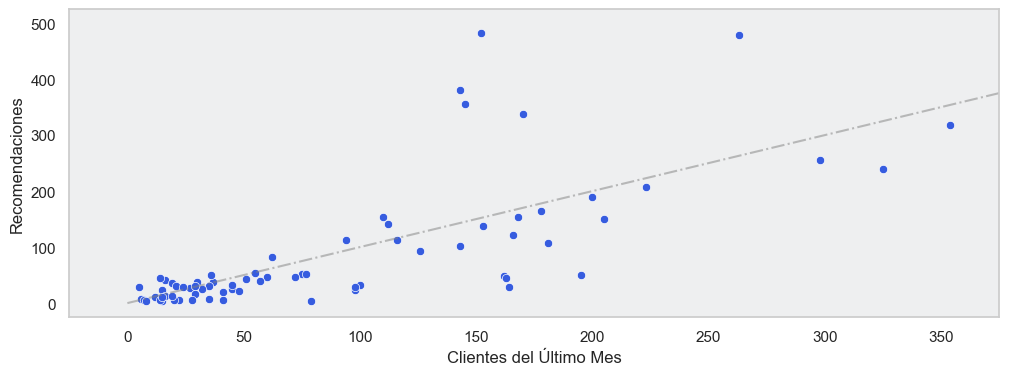

In [330]:
# Gr√°fico de dispersi√≥n para comparar las dos variables
plt.figure(figsize=(12, 4))
sns.scatterplot(x='customers_last_month', y='recomendaciones', data=df1, color=color_barras)

# Establecer el color del fondo
plt.gca().set_facecolor(color_fondo)

# Eliminar la cuadr√≠cula
plt.grid(False)

# A√±adir l√≠neas punteadas
x = np.linspace(0, 500, 100)  # Crear un rango de valores para x
plt.plot(x, x, linestyle='-.', color='grey', label='y = x', alpha=0.5)  # L√≠nea para y = x

plt.xlim(-25,375)

plt.xlabel('Clientes del √öltimo Mes')
plt.ylabel('Recomendaciones')
plt.show()

- **Correspondencia entre Recomendaciones y Clientes**: Se logra ver una relaci√≥n entre los resultados del algoritmo de recomendaci√≥n y las compras reales.
- **Sobre Recomendaci√≥n**: Algunos productos tienen muchos m√°s recomendaciones que clientes, por lo que se estar√≠an invirtiendo recursos innecesarios en esos productos.
- **Sub Recomendaci√≥n**: De la misma forma en algunos casos hay menor recomendaciones que clientes.  
- **Frecuencia de Productos**: Hay puntos concentrados principalmente en el rango inferior, lo que indica una mayor frecuencia de productos con menos clientes y recomendaciones.

In [267]:
# Coeficiente de correlaci√≥n
correlation = df1['customers_last_month'].corr(df1['recomendaciones'])
print(f"El coeficiente de correlaci√≥n entre las compras del √∫ltimo mes y las recomendaciones es: {correlation}")

El coeficiente de correlaci√≥n entre las compras del √∫ltimo mes y las recomendaciones es: 0.729986319793498


El coeficiente de correlaci√≥n de aproximadamente 0.73 indica una relaci√≥n positiva moderadamente fuerte entre las compras del √∫ltimo mes y las recomendaciones. Esto sugiere que, en general, a medida que aumenta el n√∫mero de recomendaciones, tambi√©n lo hace el n√∫mero de clientes que compran el producto. Sin embargo, la correlaci√≥n no es perfecta, lo que implica que otros factores adem√°s de las recomendaciones pueden influir en las decisiones de compra de los clientes.

#### An√°lisis de Normalidad del Error

Para comprender la efectividad del sistema de recomendaciones, se introduce la variable 'Error', que representa la diferencia entre el n√∫mero de recomendaciones dadas a un producto y la cantidad de clientes que efectivamente realizaron una compra ese mes. El an√°lisis de esta variable puede ayudarnos a identificar si las recomendaciones est√°n alineadas con el comportamiento de compra real de los clientes. Si 'Error' sigue una distribuci√≥n normal con una media cercana a cero, podr√≠amos inferir que el sistema de recomendaciones est√° funcionando bien, ya que la discrepancia entre las recomendaciones y las compras reales ser√≠a m√≠nima. Por otro lado, si la distribuci√≥n es sesgada o tiene una media significativamente distinta de cero, esto podr√≠a indicar que hay espacio para mejorar la precisi√≥n de las recomendaciones.

In [270]:
# Error entre cantidad de recomendaciones y clientes del √∫ltimo mes
df1['Error'] = df1['recomendaciones'] - df1['customers_last_month']

In [271]:
# Top productos sobre recomendados
df1.sort_values(by='Error', ascending=False).head(3)

product_desc  customers_last_month  \
23           Brahma Dorada-1/2 Lts-Cans                 152.0   
5   Andes Origen Fresquita-1/2 Lts-Cans                 143.0   
27                  Brahma-1/2 Lts-Cans                 263.0   

    recomendaciones  brand_family                   brand          pack  \
23              483        Brahma           Brahma Dorada  1/2 Lts-Cans   
5               380  Andes Origen  Andes Origen Fresquita  1/2 Lts-Cans   
27              478        Brahma                  Brahma  1/2 Lts-Cans   

   brand_segment_I  Error  
23            Core  331.0  
5           Core +  237.0  
27            Core  215.0

In [272]:
# Top productos sub recomendados
df1.sort_values(by='Error', ascending=True).head(3)

product_desc  customers_last_month  \
22        Brahma Dorada-1 Lts-Bottle-RET                 195.0   
14  Andes Origen Roja-1/3 Lts-Bottle-RET                 164.0   
87              Quilmes Ipa-1/2 Lts-Cans                 163.0   

    recomendaciones         brand_family              brand  \
22               50               Brahma      Brahma Dorada   
14               28         Andes Origen  Andes Origen Roja   
87               44  Quilmes Variedades         Quilmes Ipa   

                  pack brand_segment_I  Error  
22    1 Lts-Bottle-RET            Core -145.0  
14  1/3 Lts-Bottle-RET          Core + -136.0  
87        1/2 Lts-Cans            Core -119.0

/Users/anoguera/Documents/GitHub/MLAvanzado-Coursera/.conda/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


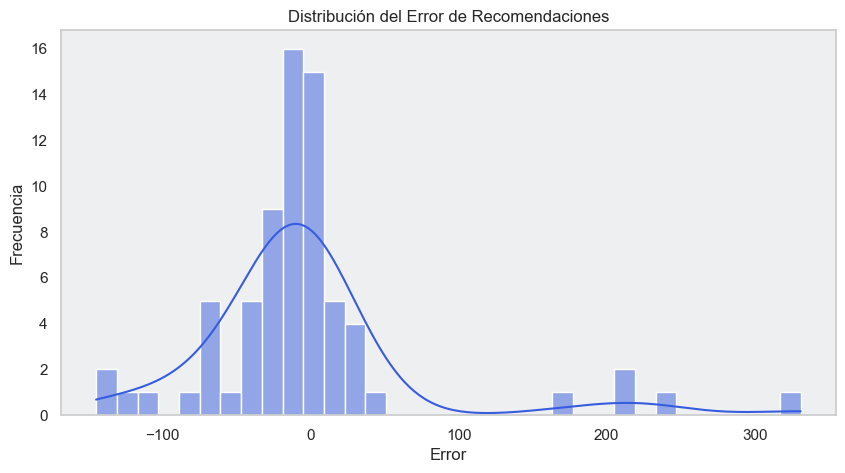

In [281]:
# Histograma de la variable 'Error'
plt.figure(figsize=(10, 5))
sns.histplot(df1['Error'], kde=True, color=color_barras)

# Establecer el color del fondo
plt.gca().set_facecolor(color_fondo)

# Eliminar la cuadr√≠cula
plt.grid(False)

plt.title('Distribuci√≥n del Error de Recomendaciones')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

In [110]:
df1['Error'].describe()

count     71.000000
mean      -3.352113
std       76.439724
min     -145.000000
25%      -26.500000
50%      -12.000000
75%        3.000000
max      331.000000
Name: Error, dtype: float64

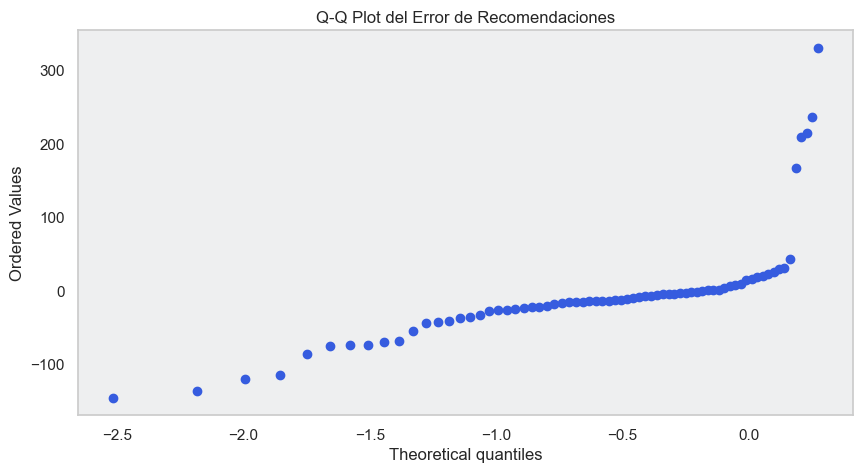

In [111]:
# Q-Q plot para verificar la normalidad de la variable 'Error'
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
stats.probplot(df1['Error'], dist="norm", plot=ax)
ax.get_lines()[0].set_color(color_barras)
ax.get_lines()[1].set_color(color_barras)
ax.title.set_text('Q-Q Plot del Error de Recomendaciones')

# Establecer el color del fondo
ax.set_facecolor(color_fondo)

# Eliminar la cuadricula
ax.grid(False)

plt.show()

- El histograma muestra una concentraci√≥n de errores alrededor de cero, lo que sugiere que muchas de las recomendaciones estuvieron cerca del n√∫mero real de clientes del √∫ltimo mes. La media es -3.35 por lo que en general las recomendaciones fueron cercanas a la cantidad de compras que se realizo.
- Sin embargo, la distribuci√≥n no es sim√©trica; hay una cola m√°s larga hacia la derecha, indicando errores donde el n√∫mero de recomendaciones excedi√≥ el n√∫mero de clientes.
- El Q-Q Plot revela que la distribuci√≥n de errores no sigue una distribuci√≥n normal, especialmente en los extremos de los cuantiles te√≥ricos. Los datos muestran una desviaci√≥n sistem√°tica de la l√≠nea en el Q-Q Plot.
- Los puntos en el extremo derecho del Q-Q Plot indican la presencia de valores at√≠picos donde las recomendaciones fueron significativamente mayores que el n√∫mero de clientes del √∫ltimo mes.

Estos puntos clave sugieren que mientras que el modelo de recomendaci√≥n es bastante preciso para la mayor√≠a de los productos, hay casos espec√≠ficos donde las recomendaciones no se alinean bien con el comportamiento real de compra de los clientes. Ser√≠a √∫til investigar m√°s a fondo estos casos at√≠picos para entender mejor las causas de las discrepancias y ajustar el modelo de recomendaci√≥n en consecuencia.

#### Producto Estrella

üåü Hay que tener en cuenta que el producto estrella de la campa√±a es la Brahma Dorada de 1 litro

Se normaliza la variable para que represente un ranking verdadero seg√∫n la posici√≥n del ranking del producto estrella y la cantidad de recomendaciones que se le hizo a ese cliente. Al normalizar la variable se presentaran los valores en un rango de 0 a 1, siendo 0 el mejor caso y 1 el peor. 

In [2148]:
# Primero, identificamos la posici√≥n en el ranking para este producto
df.loc[:, 'es_producto_estrella'] = df['product_desc'] == 'Brahma Dorada-1 Lts-Bottle-RET'

# Luego, contamos el total de recomendaciones por cliente
df.loc[:, 'total_recomendaciones'] = df.groupby('customer_id')['customer_id'].transform('count')

# Finalmente, normalizamos la posici√≥n en el ranking del producto estrella
df.loc[:, 'ranking_normalizado'] = None
mask = df['es_producto_estrella']  
df.loc[mask, 'ranking_normalizado'] = df.loc[mask, 'ranking'] / df.loc[mask, 'total_recomendaciones']

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_70866/3207032665.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'es_producto_estrella'] = df['product_desc'] == 'Brahma Dorada-1 Lts-Bottle-RET'
/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_70866/3207032665.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'total_recomendaciones'] = df.groupby('customer_id')['customer_id'].transform('count')
/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_70866/320

In [2149]:
# Proporci√≥n de Recomendaciones del Producto Estrella
recomendaciones_producto_estrella = len(df[df['es_producto_estrella']])
proporcion_recomendaciones_producto_estrella = recomendaciones_producto_estrella / len(df['customer_id'].unique())
print('Proporci√≥n de Recomendaciones del Producto Estrella: {:.2f}%'.format(proporcion_recomendaciones_producto_estrella * 100))


Proporci√≥n de Recomendaciones del Producto Estrella: 4.01%


Se le recomienda el producto foco de la compa√±ia al 4% de los clientes.
- *Exclusividad en la Recomendaci√≥n:* El hecho de que solo el 4% de los clientes reciban una recomendaci√≥n del producto estrella sugiere que el modelo de recomendaci√≥n considera este producto como una opci√≥n m√°s exclusiva o especializada.

- *Potencial de Mercado sin Explotar:* Dado que una peque√±a fracci√≥n de los clientes ve el producto estrella en sus recomendaciones, podr√≠a haber un amplio mercado potencial sin explotar que no est√° siendo alcanzado por las estrategias actuales.

In [2150]:
# Producto Estrella
df_estrella = df[df['es_producto_estrella']]
df_estrella.head()

customer_id                    product_desc  ranking brand_family  \
15        167627  Brahma Dorada-1 Lts-Bottle-RET        8       Brahma   
49        381153  Brahma Dorada-1 Lts-Bottle-RET        1       Brahma   
74        391158  Brahma Dorada-1 Lts-Bottle-RET        4       Brahma   
149       447621  Brahma Dorada-1 Lts-Bottle-RET        2       Brahma   
501       436980  Brahma Dorada-1 Lts-Bottle-RET        4       Brahma   

             brand              pack brand_segment_I litros     formato  \
15   Brahma Dorada  1 Lts-Bottle-RET            Core  1 Lts  Bottle RET   
49   Brahma Dorada  1 Lts-Bottle-RET            Core  1 Lts  Bottle RET   
74   Brahma Dorada  1 Lts-Bottle-RET            Core  1 Lts  Bottle RET   
149  Brahma Dorada  1 Lts-Bottle-RET            Core  1 Lts  Bottle RET   
501  Brahma Dorada  1 Lts-Bottle-RET            Core  1 Lts  Bottle RET   

    producto  ltrs  es_producto_estrella  total_recomendaciones  \
15    Dorada   1.0                  True                     12   
49    Dorada   1.0                  True                      2   
74    Dorada   1.0                  True                      8   
149   Dorada   1.0                  True                      9   
501   Dorada   1.0                  True                      7   

    ranking_normalizado  
15             0.666667  
49                  0.5  
74                  0.5  
149            0.222222  
501            0.571429

Se analiza la distribuci√≥n de los rankings para la Brahma Dorada. Para asi determinar si se la recomienda en posiciones altas o no.

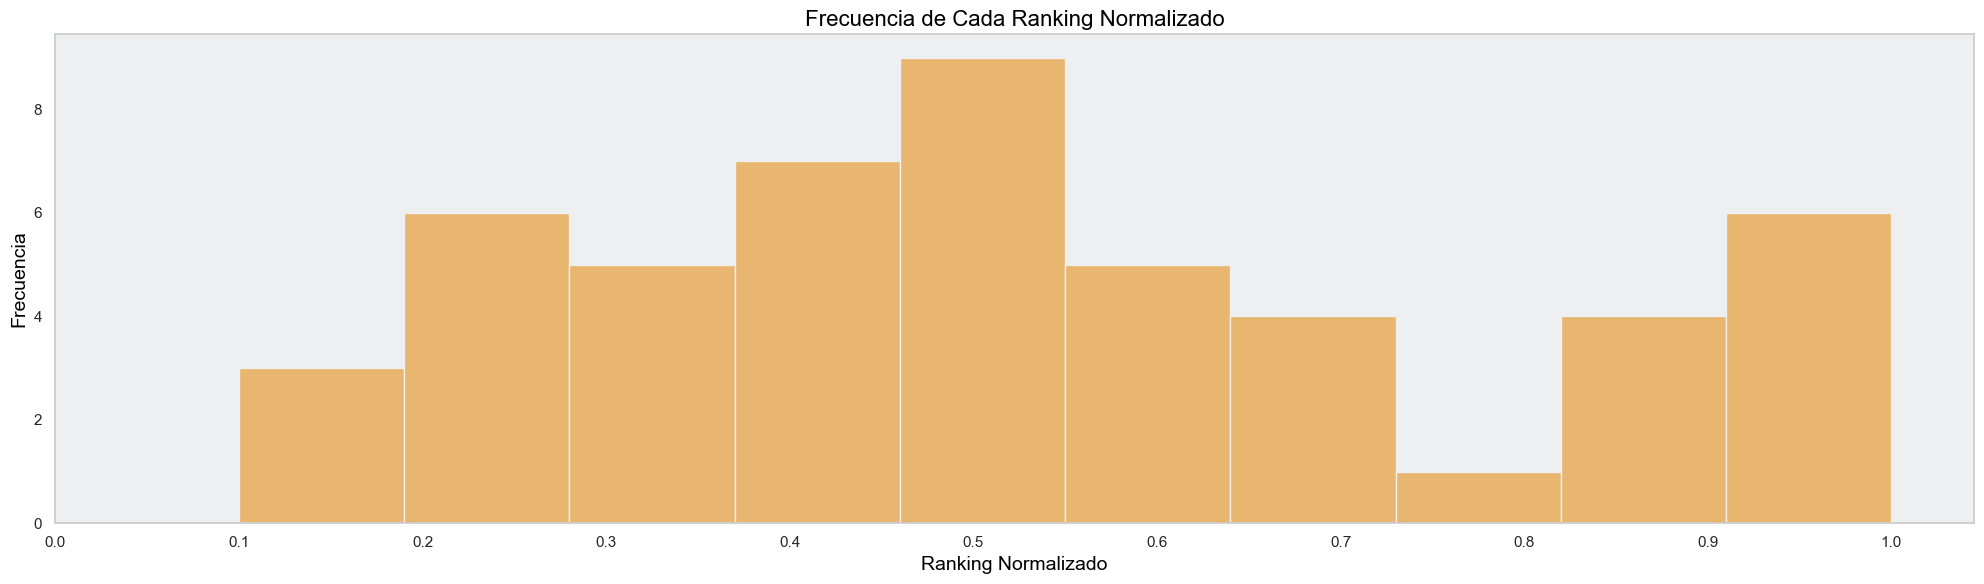

In [2151]:
# Crear el histograma
plt.figure(figsize=(20, 6))
plt.hist(df_estrella['ranking_normalizado'], bins=10, color='#E9B66F', edgecolor=color_fondo)

# Establecer el color del fondo
plt.gca().set_facecolor(color_fondo)

# Eliminar la cuadr√≠cula
plt.grid(False)

# Ajustar las etiquetas y el t√≠tulo con los colores correspondientes
plt.title('Frecuencia de Cada Ranking Normalizado', fontsize=16, color=color_texto)
plt.xlabel('Ranking Normalizado', fontsize=14, color=color_texto)
plt.ylabel('Frecuencia', fontsize=14, color=color_texto)

# Ajustar los ticks para que coincidan con los rankings enteros
plt.xticks(np.arange(0, 1.1, 0.1))

# Mostrar el gr√°fico
plt.tight_layout()
plt.show()

- *Concentraci√≥n en Rankings Menos Prioritarios:* La presencia de frecuencias m√°s altas hacia el extremo derecho del histograma indica que el producto estrella a menudo se encuentra en posiciones menos prioritarias dentro de las recomendaciones realizadas a los clientes.

- *Pocas Recomendaciones de Alta Prioridad:* Las barras m√°s bajas en los rankings normalizados m√°s bajos sugieren que el producto estrella rara vez es una de las opciones m√°s recomendadas o prioritarias.

- *Posible Mejora del Modelo:* El hecho de que el producto estrella se recomiende con frecuencia en posiciones m√°s bajas podr√≠a se√±alar una oportunidad para revisar y posiblemente mejorar c√≥mo el modelo de recomendaci√≥n valora y clasifica este producto.

- *Variabilidad en las Recomendaciones:* Hay una variabilidad en la posici√≥n que el producto estrella ocupa en las recomendaciones, lo que puede reflejar una personalizaci√≥n basada en las preferencias o el comportamiento de compra del cliente.

Este an√°lisis sugiere que el producto estrella podr√≠a no estar recibiendo la visibilidad deseada en el modelo de recomendaci√≥n actual, y se podr√≠a trabajar en estrategias para mejorar su clasificaci√≥n y, en consecuencia, potencialmente aumentar las ventas o la conversi√≥n para este producto.

## Aplicaci√≥n de Restricciones

**Objetivo**: En esta secci√≥n, aplicaremos las restricciones espec√≠ficas del ejercicio a nuestro conjunto de datos. El objetivo es ajustar las recomendaciones actuales de los productos de Quilmes para cumplir con los criterios establecidos, manteniendo la integridad y el equilibrio general de las recomendaciones.

**Procedimiento**: Utilizaremos t√©cnicas de programaci√≥n y an√°lisis de datos para modificar los objetivos de recomendaci√≥n. Esto incluir√° la implementaci√≥n de condiciones l√≥gicas y algoritmos que reajusten las recomendaciones de cada producto, asegur√°ndonos de que se cumplan las restricciones de no exceder el 200% ni caer por debajo del 75% de las recomendaciones, mantener el 20% para el segmento premium, y garantizar las recomendaciones m√≠nimas para "Brahma Dorada-1 Lts-Bottle-RET".

#### Restricciones

- **Proporci√≥n de recomendaciones sobre clientes del producto**: Debe ser menor a 200% y mayor al 75%.

ü§î *Supuesto:* En el los casos en los que no hay datos de los clientes del ultimo mes, se toma como valor el de las recomendaciones realizadas.

In [2152]:
# Se imputan los valores faltantes de la columna 'customers_last_month' con recomendaciones
df1['customers_last_month'] = df1['customers_last_month'].fillna(df1['recomendaciones'])
df1['Error'] = df1['recomendaciones'] - df1['customers_last_month']

In [2153]:
# Proporci√≥n de Recomendaciones de cada Producto
df1['Proporcion'] = df1['recomendaciones'] * 100 / df1['customers_last_month']
df1['Proporcion'].describe()

count    116.000000
mean     100.083715
std       68.226782
min        5.063291
25%       73.453815
50%      100.000000
75%      100.000000
max      560.000000
Name: Proporcion, dtype: float64

El m√≠nimo es 5.06% y el m√°ximo 560% por lo que se exceden los limites en ambos sentidos.

In [2154]:
# Infracciones de la Proporci√≥n de Recomendaciones
infracciones = df1[(df1['Proporcion'] > 200) | (df1['Proporcion'] < 75)]

In [2155]:
# Proporci√≥n de Infracciones de Recomendaciones
proporcion_infracciones = len(infracciones) / len(df1)
print('Proporci√≥n de Infracciones de Recomendaciones: {:.2f}%'.format(proporcion_infracciones * 100))

Proporci√≥n de Infracciones de Recomendaciones: 33.62%


In [2156]:
# Exceso de Recomendaciones
exceso = df1[df1['Proporcion'] > 200]
print('Proporcion de Exceso de Recomendaciones: {:.2f}%'.format(len(exceso) / len(df1) * 100))

# Deficit de Recomendaciones
deficit = df1[df1['Proporcion'] < 75]
print('Proporcion de Deficit de Recomendaciones: {:.2f}%'.format(len(deficit) / len(df1) * 100))

Proporcion de Exceso de Recomendaciones: 5.17%
Proporcion de Deficit de Recomendaciones: 28.45%


En el 33.62% de los productos no se cumple la restricci√≥n planteada.

- **Segmento Premium**: debe tener al menos el 20% de las recomendaciones totales.

In [2159]:
# Cantidad de recomendaciones por segmento
segmentos = df1.groupby('brand_segment_I')['recomendaciones'].sum().sort_values(ascending=True).reset_index(name='recomendaciones')

In [2160]:
# Proporci√≥n de recomendaciones por segmento
segmentos['Proporcion'] = round(segmentos['recomendaciones'] * 100 / segmentos['recomendaciones'].sum(),2)

In [2161]:
# Proporci√≥n de recomendaciones para el segmento Premium
prop = segmentos.loc[segmentos['brand_segment_I']=='Premium', 'Proporcion']
print(f"La proporci√≥n de recomendaciones para el segmento Premium es: {prop.values[0]}%")

La proporci√≥n de recomendaciones para el segmento Premium es: 13.89%


El segmento de productos Premium no cumple la tasa de recomendaci√≥n planteada del 20% quedando en un 13.89%.

- **Producto Estrella**: debe tener al menos 200 clientes con recomendaci√≥n.

In [2162]:
# Cantidad de recomendaciones del producto estrella
cant = df1.loc[df1['product_desc']=='Brahma Dorada-1 Lts-Bottle-RET','recomendaciones']
print(f"La cantidad de recomendaciones del producto estrella son: {cant.values[0]}")

La cantidad de recomendaciones del producto estrella son: 50


El producto estrella se le recomienda unicamente a 50 clientes, por lo que no cumple la restricci√≥n de tener al menos 200 clientes.

Para automatizar la comprobaci√≥n de si se cumplen las restricciones una vez definidos nuevos objetivos para cada uno de los productos.

In [2163]:
def comprobar_restricciones(df):
    # Calcular la proporci√≥n de recomendaciones sobre clientes
    df['Proporcion'] = df['recomendaciones'] * 100 / df['customers_last_month']

    # Comprobar la restricci√≥n de la proporci√≥n de recomendaciones
    infracciones = df[(df['Proporcion'] > 200) | (df['Proporcion'] < 75)]

    # Comprobar la restricci√≥n del segmento Premium
    segmentos = df.groupby('brand_segment_I')['recomendaciones'].sum()
    porcentaje_premium = segmentos.get('Premium', 0) * 100 / segmentos.sum()

    # Comprobar la restricci√≥n del producto estrella
    recomendaciones_producto_estrella = df[df['product_desc'] == 'Brahma Dorada-1 Lts-Bottle-RET']['recomendaciones'].sum()

    # Crear un resumen de las restricciones
    restricciones_cumplidas = {
        'Proporci√≥n Recomendaciones/Cientes': len(infracciones) == 0,
        'Segmento Premium': porcentaje_premium >= 20,
        'Producto Estrella': recomendaciones_producto_estrella >= 200
    }

    return restricciones_cumplidas

In [2164]:
# Llamada a la funci√≥n
restricciones_cumplidas = comprobar_restricciones(df1)
print(restricciones_cumplidas)

{'Proporci√≥n Recomendaciones/Cientes': False, 'Segmento Premium': False, 'Producto Estrella': False}


In [2165]:
df1.to_csv('dataAjuste.csv', index=False)

#### Estrategias de Ajuste

Se definir√°n m√©todos sistem√°ticos para modificar las recomendaciones existentes de manera que cumplan con las restricciones dadas. Esto se realiza con el fin de que todas las restricciones est√©n dentro del rango espec√≠fico definido.

**Reglas de Reajuste**:
- Para recomendaciones excesivas: Si un producto est√° siendo recomendado m√°s de lo deseado, se redistribuir√°n algunas de esas recomendaciones a productos que est√°n siendo recomendados menos.
- Para recomendaciones insuficientes: Si un producto no est√° alcanzando el umbral m√≠nimo de recomendaciones, se incrementar√° su frecuencia reduciendo la de otros productos con mayores recomendaciones.
- Mantener el foco en productos clave: El producto foco  "Brahma Dorada-1 Lts-Bottle-RET" y los que sean de segmento Premium deber√°n tener importancia en las t√©cnicas de reajuste.

**Aspectos a Tener en Cuenta**:
- Pueden ser foco de variaci√≥n aquellos productos que tengan una variaci√≥n grande entre las recomendaciones y los clientes que tuvo el mes pasado. Asi se puede lograr obtener normalidad en el error con media 0.
- El n√∫mero total de recomendaciones no puede ser modificado, pero si la distribuci√≥n entre productos. Por lo que se debe mantener el numero de recomendaciones totales de 6398.

In [2166]:
# Calculo de n√∫mero de recomendaciones
recomendaciones_totales = df1['recomendaciones'].sum()
print(f"El n√∫mero de recomendaciones totales es: {recomendaciones_totales}")

El n√∫mero de recomendaciones totales es: 6398


In [2168]:
# Convertir a entero la columna 'customers_last_month'
df1['customers_last_month'] = df1['customers_last_month'].astype(int)

#### Se prepara la informaci√≥n para el paso de optimizaci√≥n

In [ ]:
df1.to_csv('dataAjuste.csv', index=False)